# Antidot and 2PF with quantum jump

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla

plt.rcParams['text.usetex']=True
plt.rcParams['font.size']=26

In [2]:
# Definition of constants
phi = np.arctan(1/np.sqrt(27)) ### Phase of the PF coupling
lam = 2.4e3*2*np.pi ### Angular frequency measure in units of 1/{\mu}s
eps = lam ### PF overlap energy
delAD = lam/2000 ### Antidot energy splitting delta_ad
Gam = lam*0.1 ### Measurement rate between lead and PF 1
etaAD1 = np.exp(1j*0.)*lam*0.005 ### PF1-AD coupling
etaAD2 = np.exp(1j*0.)*lam*0.005 ### PF2-AD coupling
beta = (3/lam) ### Inverse temperature
tL = 1j*np.sqrt(Gam) ### Amplitude of the jump operators
tres = 1e-2 ### Resolution time in units of {\mu}s
dt =1e-4 ### Time step in units of {\mu}s
tb= 1e-1 ### The integration time in units of {\mu}s (t_avg in article) 
Nshort = round(tres/dt) ### Number of time steps in the "short time" simulation
Nlong=Nshort*1000 ### ... "long time" simulation
Navg=round(tb/dt) ### The number time steps averaged over for finding the current
Vfix=2.6*lam ### Fixed voltage

In [3]:
E0=-2*eps*np.cos(phi)
E1=-2*eps*np.cos(np.pi/3+phi)
E2=-2*eps*np.cos(np.pi*2/3+phi)
E3=-E0
E4=-E1
E5=-E2
Hsys=np.array([[E0,0,0,0,0,0,0,0,0,0,0,etaAD1+etaAD2*np.exp(-1j*np.pi*(1+2*5)/6)],
               [0,E0+delAD,etaAD1.conj()+etaAD2.conj()*np.exp(1j*np.pi/6),0,0,0,0,0,0,0,0,0],
               [0,etaAD1+etaAD2*np.exp(-1j*np.pi/6),E1,0,0,0,0,0,0,0,0,0],
               [0,0,0,E1+delAD,etaAD1.conj()+etaAD2.conj()*np.exp(1j*np.pi*(1+2*1)/6),0,0,0,0,0,0,0],
               [0,0,0,etaAD1+etaAD2*np.exp(-1j*np.pi*(1+2*1)/6),E2,0,0,0,0,0,0,0],
               [0,0,0,0,0,E2+delAD,etaAD1.conj()+etaAD2.conj()*np.exp(1j*np.pi*(1+2*2)/6),0,0,0,0,0],
               [0,0,0,0,0,etaAD1+etaAD2*np.exp(-1j*np.pi*(1+2*2)/6),E3,0,0,0,0,0],
               [0,0,0,0,0,0,0,E3+delAD,etaAD1.conj()+etaAD2.conj()*np.exp(1j*np.pi*(1+2*3)/6),0,0,0],
               [0,0,0,0,0,0,0,etaAD1+etaAD2*np.exp(-1j*np.pi*(1+2*3)/6),E4,0,0,0],
               [0,0,0,0,0,0,0,0,0,E4+delAD,etaAD1.conj()+etaAD2.conj()*np.exp(1j*np.pi*(1+2*4)/6),0],
               [0,0,0,0,0,0,0,0,0,etaAD1+etaAD2*np.exp(-1j*np.pi*(1+2*4)/6),E5,0],
               [etaAD1.conj()+etaAD2.conj()*np.exp(1j*np.pi*(1+2*5)/6),0,0,0,0,0,0,0,0,0,0,E5+delAD]])

Qtot = np.diag([0.,1,1,2,2,0,0,1,1,2,2,0]) ### The Q_tot operator

In [4]:
q03ad0 = np.array([1./np.sqrt(2),0,0,0,0,0,1./np.sqrt(2),0,0,0,0,0], dtype=complex)
q14ad0 = np.array([0,0,1./np.sqrt(2),0,0,0,0,0,1./np.sqrt(2),0,0,0], dtype=complex)
q25ad0 = np.array([0,0,0,0,1./np.sqrt(2),0,0,0,0,0,1./np.sqrt(2),0], dtype=complex)
q03ad1 = np.array([0,1./np.sqrt(2),0,0,0,0,0,1./np.sqrt(2),0,0,0,0], dtype=complex)
q14ad1 = np.array([0,0,0,1./np.sqrt(2),0,0,0,0,0,1./np.sqrt(2),0,0], dtype=complex)
q25ad1 = np.array([0,0,0,0,0,1./np.sqrt(2),0,0,0,0,0,1./np.sqrt(2)], dtype=complex)
qeq =np.array([1./np.sqrt(12),1/np.sqrt(12),1/np.sqrt(12),1/np.sqrt(12),1/np.sqrt(12),1/np.sqrt(12),1./np.sqrt(12),1/np.sqrt(12),1/np.sqrt(12),1/np.sqrt(12),1/np.sqrt(12),1/np.sqrt(12)], dtype=complex)

In [5]:
def L1AD(V): ### Here we define the jump operator L+ as a function of voltage
    L1AD_ret = np.zeros((12,12), dtype=complex)
    L1AD_ret[0, 6] = tL*np.sqrt(1/(1+np.exp(beta*(E0-E3-V))))
    L1AD_ret[1, 7] = tL*np.sqrt(1/(1+np.exp(beta*(E0-E3-V))))
    L1AD_ret[2, 8] = tL*np.sqrt(1/(1+np.exp(beta*(E1-E4-V))))
    L1AD_ret[3, 9] = tL*np.sqrt(1/(1+np.exp(beta*(E1-E4-V))))
    L1AD_ret[4, 10] = tL*np.sqrt(1/(1+np.exp(beta*(E2-E5-V))))
    L1AD_ret[5, 11] = tL*np.sqrt(1/(1+np.exp(beta*(E2-E5-V))))
    L1AD_ret[6, 0] = tL*np.sqrt(1/(1+np.exp(beta*(E3-E0-V))))
    L1AD_ret[7, 1] = tL*np.sqrt(1/(1+np.exp(beta*(E3-E0-V))))
    L1AD_ret[8, 2] = tL*np.sqrt(1/(1+np.exp(beta*(E4-E1-V))))
    L1AD_ret[9, 3] = tL*np.sqrt(1/(1+np.exp(beta*(E4-E1-V))))
    L1AD_ret[10, 4] = tL*np.sqrt(1/(1+np.exp(beta*(E5-E2-V))))
    L1AD_ret[11, 5] = tL*np.sqrt(1/(1+np.exp(beta*(E5-E2-V))))
    return L1AD_ret

def L2AD(V): ### Here we define the jump operator L- as a function of voltage
    L2AD_ret = np.zeros((12,12), dtype=complex) 
    L2AD_ret[0, 6] = tL*np.sqrt(1-1/(1+np.exp(beta*(E3-E0-V)))) 
    L2AD_ret[1, 7] = tL*np.sqrt(1-1/(1+np.exp(beta*(E3-E0-V))))
    L2AD_ret[2, 8] = tL*np.sqrt(1-1/(1+np.exp(beta*(E4-E1-V))))
    L2AD_ret[3, 9] = tL*np.sqrt(1-1/(1+np.exp(beta*(E4-E1-V))))
    L2AD_ret[4, 10] = tL*np.sqrt(1-1/(1+np.exp(beta*(E5-E2-V))))
    L2AD_ret[5, 11] = tL*np.sqrt(1-1/(1+np.exp(beta*(E5-E2-V))))
    L2AD_ret[6, 0] = tL*np.sqrt(1-1/(1+np.exp(beta*(E0-E3-V))))
    L2AD_ret[7, 1] = tL*np.sqrt(1-1/(1+np.exp(beta*(E0-E3-V))))
    L2AD_ret[8, 2] = tL*np.sqrt(1-1/(1+np.exp(beta*(E1-E4-V))))
    L2AD_ret[9, 3] = tL*np.sqrt(1-1/(1+np.exp(beta*(E1-E4-V))))
    L2AD_ret[10, 4] = tL*np.sqrt(1-1/(1+np.exp(beta*(E2-E5-V))))
    L2AD_ret[11, 5] = tL*np.sqrt(1-1/(1+np.exp(beta*(E2-E5-V))))
    return L2AD_ret

In [6]:
def UAD(V): ### Here we define the no-jump evolution operator
    UAD_ret = sla.expm((-1j*dt)*(Hsys-1j*((L1AD(V).T.conj())@L1AD(V)+(L2AD(V).T.conj())@L2AD(V))/2))
    return UAD_ret

In [61]:
epeta=((E0-E5-delAD)/2)/abs(etaAD1)
Pshift=(np.sin(np.sqrt(epeta**2+1)))**2/(epeta**2+1)
print(Pshift)

4.4149522045575775e-05


In [7]:
Nt=5*Nlong
ttab=np.linspace(tb,Nt*dt,Nt-Navg)

In [8]:
st = q03ad0
Umat=UAD(Vfix)
L1mat=L1AD(Vfix)
L2mat=L2AD(Vfix)
Jdiffq03ad0=[]
j1=0
j2=0
for i in range(1,Nt+1):
    stnj = Umat@st
    stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
    L1st = L1mat@stnjR
    L2st = L2mat@stnjR
    Pj1 = dt*(np.vdot(L1st,L1st)).real
    Pj2 = dt*(np.vdot(L2st,L2st)).real
    P=np.random.uniform()
    P1=np.random.uniform()
    P2=np.random.uniform()
    if P<0.5:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    else:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1+0
            j2=j2+1
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    Jdiffq03ad0.append(j1-j2)

In [9]:
st = q14ad0
Umat=UAD(Vfix)
L1mat=L1AD(Vfix)
L2mat=L2AD(Vfix)
Jdiffq14ad0=[]
j1=0
j2=0
for i in range(1,Nt+1):
    stnj = Umat@st
    stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
    L1st = L1mat@stnjR
    L2st = L2mat@stnjR
    Pj1 = dt*(np.vdot(L1st,L1st)).real
    Pj2 = dt*(np.vdot(L2st,L2st)).real
    P=np.random.uniform()
    P1=np.random.uniform()
    P2=np.random.uniform()
    if P<0.5:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    else:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1+0
            j2=j2+1
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    Jdiffq14ad0.append(j1-j2)

In [10]:
st = q25ad0
Umat=UAD(Vfix)
L1mat=L1AD(Vfix)
L2mat=L2AD(Vfix)
Jdiffq25ad0=[]
j1=0
j2=0
for i in range(1,Nt+1):
    stnj = Umat@st
    stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
    L1st = L1mat@stnjR
    L2st = L2mat@stnjR
    Pj1 = dt*(np.vdot(L1st,L1st)).real
    Pj2 = dt*(np.vdot(L2st,L2st)).real
    P=np.random.uniform()
    P1=np.random.uniform()
    P2=np.random.uniform()
    if P<0.5:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    else:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1+0
            j2=j2+1
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    Jdiffq25ad0.append(j1-j2)

In [11]:
st = q03ad1
Umat=UAD(Vfix)
L1mat=L1AD(Vfix)
L2mat=L2AD(Vfix)
Jdiffq03ad1=[]
j1=0
j2=0
for i in range(1,Nt+1):
    stnj = Umat@st
    stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
    L1st = L1mat@stnjR
    L2st = L2mat@stnjR
    Pj1 = dt*(np.vdot(L1st,L1st)).real
    Pj2 = dt*(np.vdot(L2st,L2st)).real
    P=np.random.uniform()
    P1=np.random.uniform()
    P2=np.random.uniform()
    if P<0.5:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    else:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1+0
            j2=j2+1
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    Jdiffq03ad1.append(j1-j2)

In [12]:
st = q14ad1
Umat=UAD(Vfix)
L1mat=L1AD(Vfix)
L2mat=L2AD(Vfix)
Jdiffq14ad1=[]
j1=0
j2=0
for i in range(1,Nt+1):
    stnj = Umat@st
    stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
    L1st = L1mat@stnjR
    L2st = L2mat@stnjR
    Pj1 = dt*(np.vdot(L1st,L1st)).real
    Pj2 = dt*(np.vdot(L2st,L2st)).real
    P=np.random.uniform()
    P1=np.random.uniform()
    P2=np.random.uniform()
    if P<0.5:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    else:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1+0
            j2=j2+1
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    Jdiffq14ad1.append(j1-j2)

In [13]:
st = q25ad1
Umat=UAD(Vfix)
L1mat=L1AD(Vfix)
L2mat=L2AD(Vfix)
Jdiffq25ad1=[]
j1=0
j2=0
for i in range(1,Nt+1):
    stnj = Umat@st
    stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
    L1st = L1mat@stnjR
    L2st = L2mat@stnjR
    Pj1 = dt*(np.vdot(L1st,L1st)).real
    Pj2 = dt*(np.vdot(L2st,L2st)).real
    P=np.random.uniform()
    P1=np.random.uniform()
    P2=np.random.uniform()
    if P<0.5:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    else:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1+0
            j2=j2+1
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    Jdiffq25ad1.append(j1-j2)

In [14]:
st = qeq
Umat=UAD(Vfix)
L1mat=L1AD(Vfix)
L2mat=L2AD(Vfix)
Jdiffqeq=[]
sttab=[qeq]
j1=0
j2=0
for i in range(1,Nt+1):
    stnj = Umat@st
    stnjR = stnj/np.sqrt(np.vdot(stnj,stnj))
    L1st = L1mat@stnjR
    L2st = L2mat@stnjR
    Pj1 = dt*(np.vdot(L1st,L1st)).real
    Pj2 = dt*(np.vdot(L2st,L2st)).real
    P=np.random.uniform()
    P1=np.random.uniform()
    P2=np.random.uniform()
    if P<0.5:
        if P1<Pj1:
            st=L1st/np.sqrt(Pj1/dt)
            j1=j1+1
            j2=j2+0
        else:
            if P2<Pj2:
                st=L2st/np.sqrt(Pj2/dt)
                j1=j1+0
                j2=j2+1
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    else:
        if P2<Pj2:
            st=L2st/np.sqrt(Pj2/dt)
            j1=j1+0
            j2=j2+1
        else:
            if P1<Pj1:
                st=L1st/np.sqrt(Pj1/dt)
                j1=j1+1
                j2=j2+0
            else:
                st=stnjR
                j1=j1+0
                j2=j2+0
    sttab.append(st)
    Jdiffqeq.append(j1-j2)

In [15]:
Jarrq03ad0=np.array(Jdiffq03ad0)
Itabq03ad0=[]
for i in range(Navg, Nt):
    curr=1e12*1.6e-19*(Jarrq03ad0[i]-Jarrq03ad0[i-Navg])/(tb*1e-6)
    Itabq03ad0.append(curr)
    
Iarr03ad0=np.array(Itabq03ad0)

In [16]:
Jarrq14ad0=np.array(Jdiffq14ad0)
Itabq14ad0=[]
for i in range(Navg, Nt):
    curr=1e12*1.6e-19*(Jarrq14ad0[i]-Jarrq14ad0[i-Navg])/(tb*1e-6)
    Itabq14ad0.append(curr)
    
Iarr14ad0=np.array(Itabq14ad0)

In [17]:
Jarrq25ad0=np.array(Jdiffq25ad0)
Itabq25ad0=[]
for i in range(Navg, Nt):
    curr=1e12*1.6e-19*(Jarrq25ad0[i]-Jarrq25ad0[i-Navg])/(tb*1e-6)
    Itabq25ad0.append(curr)
    
Iarr25ad0=np.array(Itabq25ad0)

In [18]:
Jarrq03ad1=np.array(Jdiffq03ad1)
Itabq03ad1=[]
for i in range(Navg, Nt):
    curr=1e12*1.6e-19*(Jarrq03ad1[i]-Jarrq03ad1[i-Navg])/(tb*1e-6)
    Itabq03ad1.append(curr)
    
Iarr03ad1=np.array(Itabq03ad1)

In [19]:
Jarrq14ad1=np.array(Jdiffq14ad1)
Itabq14ad1=[]
for i in range(Navg, Nt):
    curr=1e12*1.6e-19*(Jarrq14ad1[i]-Jarrq14ad1[i-Navg])/(tb*1e-6)
    Itabq14ad1.append(curr)
    
Iarr14ad1=np.array(Itabq14ad1)

In [20]:
Jarrq25ad1=np.array(Jdiffq25ad1)
Itabq25ad1=[]
for i in range(Navg, Nt):
    curr=1e12*1.6e-19*(Jarrq25ad1[i]-Jarrq25ad1[i-Navg])/(tb*1e-6)
    Itabq25ad1.append(curr)
    
Iarr25ad1=np.array(Itabq25ad1)

In [21]:
Jarrqeq=np.array(Jdiffqeq)
Itabqeq=[]
for i in range(Navg, Nt):
    curr=1e12*1.6e-19*(Jarrqeq[i]-Jarrqeq[i-Navg])/(tb*1e-6)
    Itabqeq.append(curr)
    
Iarreq=np.array(Itabqeq)

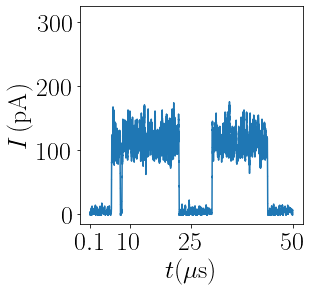

In [31]:
fig, ax = plt.subplots(figsize=(4,4)) 
ax.set_xlabel(r'$t(\mu {\rm s})$')
ax.set_ylabel(r'$I\, ({\rm pA})$')
ax.set_xticks(np.array([tb,Nt*dt/5,Nt*dt/2,Nt*dt]), labels=['$0.1$','$10$','$25$','$50$'])
ax.set_yticks(np.array([0,100,200,300]))
plt.plot(ttab,Iarr03ad0,color='tab:blue')
#plt.plot(ttab,Iarr14ad0,color='tab:orange')
#plt.plot(ttab,Iarr25ad0,color='tab:green')
plt.ylim(ymax=325,ymin=-15)
plt.show()

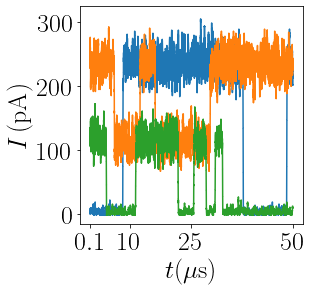

In [33]:
fig, ax = plt.subplots(figsize=(4,4)) 
ax.set_xlabel(r'$t(\mu {\rm s})$')
ax.set_ylabel(r'$I\, ({\rm pA})$')
ax.set_xticks(np.array([tb,Nt*dt/5,Nt*dt/2,Nt*dt]), labels=['$0.1$','$10$','$25$','$50$'])
ax.set_yticks(np.array([0,100,200,300]))
plt.plot(ttab,Iarr03ad1,color='tab:blue')
plt.plot(ttab,Iarr14ad1,color='tab:orange')
plt.plot(ttab,Iarr25ad1,color='tab:green')
plt.ylim(ymax=325,ymin=-15)
plt.show() 

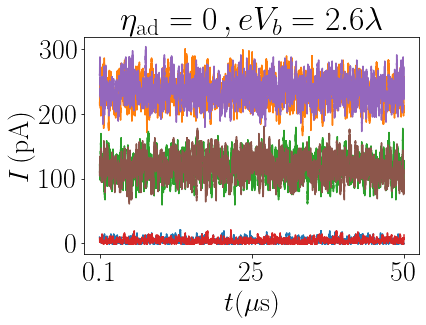

In [86]:
fig, ax = plt.subplots() ### To create this plot set etaAD1=etaAD2=0 at the top
ax.set_xlabel(r'$t(\mu {\rm s})$')
ax.set_ylabel(r'$I\, ({\rm pA})$')
ax.set_title(r'$\eta_{\rm ad}=0\,, eV_b=2.6\lambda$')
ax.set_xticks(np.array([tb,2500*tres,5000*tres]), labels=['$0.1$','$25$','$50$'])
ax.set_yticks(np.array([0,100,200,300]))
plt.plot(ttab,Iarr03ad0)
plt.plot(ttab,Iarr14ad0)
plt.plot(ttab,Iarr25ad0)
plt.plot(ttab,Iarr03ad1)
plt.plot(ttab,Iarr14ad1)
plt.plot(ttab,Iarr25ad1)
plt.show()

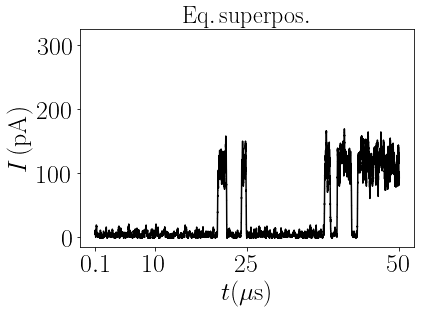

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$t(\mu {\rm s})$')
ax.set_ylabel(r'$I\, ({\rm pA})$')
ax.set_title(r'${\rm Eq.\, superpos.}$',fontsize=24)
ax.set_xticks(np.array([tb,1000*tres,2500*tres,5000*tres]), labels=['$0.1$','$10$','$25$','$50$'])
ax.set_yticks(np.array([0,100,200,300]))
plt.plot(ttab,Iarreq,color='k')
plt.ylim(ymax=325,ymin=-15)
plt.show()

In [ ]:
### To investigate when the first jump to another current level takes place, run many loops (10000 in the example below) of the quantum jump evolution above for the corresponding initial state.

In [ ]:
jumpq03ad0=[]
for l in range(10000):
    for i in range(3,len(ttab)):
        if Iarr03ad0[l,i]>80 and Iarr03ad0[l,i-1]>80 and Iarr03ad0[l,i-2]>80:
            break
    jumpq03ad0.append(i*dt)

firstjumpq03ad0=np.array(jumpq03ad0)

In [ ]:
jumpq14ad0=[]
for l in range(10000):
    for i in range(3,len(ttab)):
        if Iarr14ad0[l,i]<100 and Iarr14ad0[l,i-1]<100 and Iarr14ad0[l,i-2]<100:
            break
    jumpq14ad0.append(i*dt)

firstjumpq14ad0=np.array(jumpq14ad0)

In [ ]:
jumpq25ad0=[]
for l in range(10000):
    for i in range(3,len(ttab)):
        if Iarr25ad0[l,i]>200 and Iarr25ad0[l,i-1]>200 and Iarr25ad0[l,i-2]>200:
            break
    jumpq25ad0.append(i*dt)

firstjumpq25ad0=np.array(jumpq25ad0)

In [ ]:
jumpq03ad1=[]
for l in range(10000):
    for i in range(3,len(ttab)):
        if Iarr03ad1[l,i]>150 and Iarr03ad1[l,i-1]>150 and Iarr03ad1[l,i-2]>150:
            break
    jumpq03ad1.append(i*dt)

firstjumpq03ad1=np.array(jumpq03ad1)

In [ ]:
jumpq14ad1=[]
for l in range(10000):
    for i in range(3,len(ttab)):
        if Iarr14ad1[l,i]<180 and Iarr14ad1[l,i-1]<180 and Iarr14ad1[l,i-2]<180:
            break
    jumpq14ad1.append(i*dt)

firstjumpq14ad1=np.array(jumpq14ad1)

In [ ]:
jumpq25ad1=[]
for l in range(10000):
    for i in range(3,len(ttab)):
        if Iarr25ad1[l,i]<50 and Iarr25ad1[l,i-1]<50 and Iarr25ad1[l,i-2]<50:
            break
    jumpq25ad1.append(i*dt)

firstjumpq25ad1=np.array(jumpq25ad1)

In [4]:
t_ad=2*np.pi/abs(etaAD1)

In [5]:
fastshiftq03ad0=0
for i in range(len(firstjumpq03ad0)):
    if firstjumpq03ad0[i] <t_ad:
        fastshiftq03ad0=fastshiftq03ad0+1
        
fastshiftq14ad0=0
for i in range(len(firstjumpq14ad0)):
    if firstjumpq14ad0[i] <t_ad:
        fastshiftq14ad0=fastshiftq14ad0+1
        
fastshiftq25ad0=0
for i in range(len(firstjumpq25ad0)):
    if firstjumpq25ad0[i] <t_ad:
        fastshiftq25ad0=fastshiftq25ad0+1
        
fastshiftq03ad1=0
for i in range(len(firstjumpq03ad1)):
    if firstjumpq03ad1[i] <t_ad:
        fastshiftq03ad1=fastshiftq03ad1+1
        
fastshiftq14ad1=0
for i in range(len(firstjumpq14ad1)):
    if firstjumpq14ad1[i] <t_ad:
        fastshiftq14ad1=fastshiftq14ad1+1
        
fastshiftq25ad1=0
for i in range(len(firstjumpq25ad1)):
    if firstjumpq25ad1[i] <t_ad:
        fastshiftq25ad1=fastshiftq25ad1+1

In [6]:
print(fastshiftq03ad0/10000,fastshiftq14ad0/10000,fastshiftq25ad0/10000,fastshiftq03ad1/10000,fastshiftq14ad1/10000,fastshiftq25ad1/10000)

0.0198 0.0034 0.0051 0.0078 0.0104 0.0172


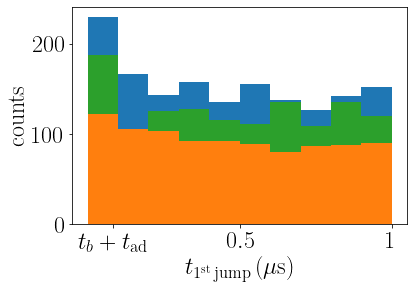

In [8]:
fig,ax=plt.subplots()
ax.set_xlabel(r'$t_{1^{\rm st}\, \rm jump}\, (\mu {\rm s})$')
ax.set_ylabel(r'\rm counts')
ax.set_xticks(np.array([t_ad,0.5,1]), labels=[r'$t_b+t_{\rm ad}$','$0.5$','$1$'])
plt.hist(firstjumpq03ad0,range=(0,1))
plt.hist(firstjumpq25ad1,range=(0,1),color='tab:green')
plt.hist(firstjumpq14ad1,range=(0,1))
plt.show()